# Architecture Reconstruction for Zeeguu

This notebook provides a comprehensive architecture reconstruction for the Zeeguu system, analyzing both the backend API (`../Data/api`) and frontend (`../Data/frontend`). The goal is to extract meaningful architectural views that provide insights into the system's structure, dependencies, and complexity.

## 1. Setup and Installation

Install all the necessary packages for our analysis.

In [4]:
import sys
import subprocess
#!{sys.executable} -m pip install prospector pylint networkx matplotlib pyyaml jinja2 pandas graphviz pydot

def install_package(package):
    package_name = package.split('==')[0] if '==' in package else package
    try:
        __import__(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
install_package('prospector')
install_package('pylint')
install_package('networkx')
install_package('matplotlib')
install_package('pyyaml')
install_package('jinja2')
install_package('pandas')
install_package('graphviz')
install_package('pydot')

prospector is already installed.
pylint is already installed.
networkx is already installed.
matplotlib is already installed.
Installing pyyaml...
jinja2 is already installed.
pandas is already installed.
graphviz is already installed.
pydot is already installed.


## 1. Setup, & Basic System Information & basic prospector


In [13]:
import os
import subprocess
import json

# Define absolute paths based on your project structure
API_PATH = r"C:\Programming\Architecture\ArchitecturalRecovery\Data\api"
FRONTEND_PATH = r"C:\Programming\Architecture\ArchitecturalRecovery\Data\frontend"
OUTPUT_DIR = r"C:\Programming\Architecture\ArchitecturalRecovery\Tools"  # Adjust as needed

def count_files_and_lines(path, extensions=None):
    """
    Count files and lines of code in the given path, filtered by file extensions.
    """
    if extensions is None:
        extensions = ['.py', '.js', '.jsx', '.ts', '.tsx']
    
    file_count = 0
    line_count = 0
    files_by_ext = {ext: 0 for ext in extensions}
    lines_by_ext = {ext: 0 for ext in extensions}
    
    for root, _, files in os.walk(path):
        for file in files:
            _, ext = os.path.splitext(file)
            if ext in extensions:
                file_count += 1
                files_by_ext[ext] += 1
                
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        lines = len(f.readlines())
                        line_count += lines
                        lines_by_ext[ext] += lines
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    return {
        'total_files': file_count,
        'total_lines': line_count,
        'files_by_ext': files_by_ext,
        'lines_by_ext': lines_by_ext
    }

# Analyze backend
backend_stats = count_files_and_lines(API_PATH)
print("Backend Statistics:")
print(json.dumps(backend_stats, indent=2))

# Analyze frontend
frontend_stats = count_files_and_lines(FRONTEND_PATH)
print("\nFrontend Statistics:")
print(json.dumps(frontend_stats, indent=2))

def run_prospector(path, output_file):
    """
    Run Prospector on the specified path and save results to output_file.
    Returns a summary of findings.
    """
    full_output_path = os.path.join(OUTPUT_DIR, output_file)
    
    try:
        # Run Prospector without forcing a check on the exit status
        result = subprocess.run(
            ['python', '-m', 'prospector', path, '--output-format=json'],
            capture_output=True, text=True, check=False
        )
        
        # If there's any stderr output, print it for debugging purposes
        if result.stderr:
            print(f"Prospector stderr for {path}:")
            print(result.stderr)
        
        # Attempt to parse JSON output even if exit status is non-zero
        try:
            results = json.loads(result.stdout)
        except Exception as parse_error:
            print(f"Error parsing Prospector JSON output for {path}: {parse_error}")
            return None

        # Write the output to a file
        with open(full_output_path, 'w', encoding='utf-8') as f:
            f.write(result.stdout)
        
        print(f"Prospector analysis completed for {path}")
        
        messages = results.get('messages', [])
        tools_used = results.get('tools', [])
        summary = {
            'total_issues': len(messages),
            'tools_used': tools_used,
            'issues_by_type': {}
        }
        
        for msg in messages:
            msg_type = msg.get('source')
            if msg_type not in summary['issues_by_type']:
                summary['issues_by_type'][msg_type] = 0
            summary['issues_by_type'][msg_type] += 1
            
        return summary
    except Exception as e:
        print(f"Error running Prospector on {path}: {e}")
        return None

# Run Prospector on backend
backend_prospector = run_prospector(API_PATH, 'api_prospector_report.json')
print("\nBackend Prospector Summary:")
print(json.dumps(backend_prospector, indent=2))

# Run Prospector on frontend
frontend_prospector = run_prospector(FRONTEND_PATH, 'frontend_prospector_report.json')
print("\nFrontend Prospector Summary:")
print(json.dumps(frontend_prospector, indent=2))


Backend Statistics:
{
  "total_files": 356,
  "total_lines": 31256,
  "files_by_ext": {
    ".py": 356,
    ".js": 0,
    ".jsx": 0,
    ".ts": 0,
    ".tsx": 0
  },
  "lines_by_ext": {
    ".py": 31256,
    ".js": 0,
    ".jsx": 0,
    ".ts": 0,
    ".tsx": 0
  }
}

Frontend Statistics:
{
  "total_files": 472,
  "total_lines": 36629,
  "files_by_ext": {
    ".py": 0,
    ".js": 472,
    ".jsx": 0,
    ".ts": 0,
    ".tsx": 0
  },
  "lines_by_ext": {
    ".py": 0,
    ".js": 36629,
    ".jsx": 0,
    ".ts": 0,
    ".tsx": 0
  }
}


KeyboardInterrupt: 

## 5. Module Dependency Analysis

Extract and visualize module dependencies using PyDepend for the backend and a custom import parser for the frontend.

In [5]:
def extract_dependencies(path, is_backend=True):
    """
    Extract module dependencies from the given path.
    For the backend (Python), use pydepend.
    For the frontend (JavaScript/React), parse import statements.
    """
    if is_backend:
        output_path = os.path.join(OUTPUT_DIR, 'api_dependencies.dot')
        cmd = ['pydepend', '--ext-direct=dot', '-o', output_path, path]
        
        try:
            subprocess.run(cmd, check=True)
            print(f"Dependency extraction completed for {path}")
            
            # Parse the dot file to create a NetworkX graph
            G = nx.drawing.nx_pydot.read_dot(output_path)
            return G
        except Exception as e:
            print(f"Error extracting dependencies for {path}: {e}")
            # Fallback: use pyreverse
            try:
                output_prefix = os.path.join(OUTPUT_DIR, 'api_dependencies')
                cmd = ['pyreverse', '-o', 'dot', '-p', 'zeeguu', path]
                subprocess.run(cmd, check=True)
                # pyreverse creates classes.dot and packages.dot
                G = nx.drawing.nx_pydot.read_dot('classes.dot')
                os.rename('classes.dot', os.path.join(OUTPUT_DIR, 'classes.dot'))
                os.rename('packages.dot', os.path.join(OUTPUT_DIR, 'packages.dot'))
                return G
            except Exception as e2:
                print(f"Error using pyreverse: {e2}")
                return nx.DiGraph()
    else:
        # For the frontend, use a custom parser for import statements
        G = nx.DiGraph()
        
        import re
        import_patterns = [
            (r"import\s+([\w\s,{}]+)\s+from\s+['\"](.*)['\"]", lambda m: (m.group(2), m.group(1))),
            (r"import\s+['\"](.*)['\"]", lambda m: (m.group(1), None))
        ]
        
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith(('.js', '.jsx', '.ts', '.tsx')):
                    file_path = os.path.join(root, file)
                    rel_path = os.path.relpath(file_path, path)
                    
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            
                            for pattern, extractor in import_patterns:
                                for match in re.finditer(pattern, content):
                                    imported_module, _ = extractor(match)
                                    
                                    # Skip external dependencies (non-relative imports)
                                    if not imported_module.startswith('.'):
                                        continue
                                    
                                    # Normalize relative path
                                    target_path = os.path.normpath(os.path.join(os.path.dirname(rel_path), imported_module))
                                    G.add_edge(rel_path, target_path)
                    except Exception as e:
                        print(f"Error parsing {file_path}: {e}")
        
        return G

# Extract backend dependencies
try:
    backend_deps = extract_dependencies(API_PATH, is_backend=True)
    print(f"Backend dependency graph has {backend_deps.number_of_nodes()} nodes and {backend_deps.number_of_edges()} edges")
except Exception as e:
    print(f"Could not extract backend dependencies: {e}")
    backend_deps = nx.DiGraph()

# Extract frontend dependencies
try:
    frontend_deps = extract_dependencies(FRONTEND_PATH, is_backend=False)
    print(f"Frontend dependency graph has {frontend_deps.number_of_nodes()} nodes and {frontend_deps.number_of_edges()} edges")
except Exception as e:
    print(f"Could not extract frontend dependencies: {e}")
    frontend_deps = nx.DiGraph()

Error extracting dependencies for ..\Data\api: [WinError 2] The system cannot find the file specified
Error using pyreverse: [Errno 2] No such file or directory: 'classes.dot'
Backend dependency graph has 0 nodes and 0 edges
Frontend dependency graph has 729 nodes and 1508 edges


## 6. Visualizing Dependency Graphs

Below is a simple visualization of the dependency graphs for the backend and frontend.

No backend dependency graph to display.


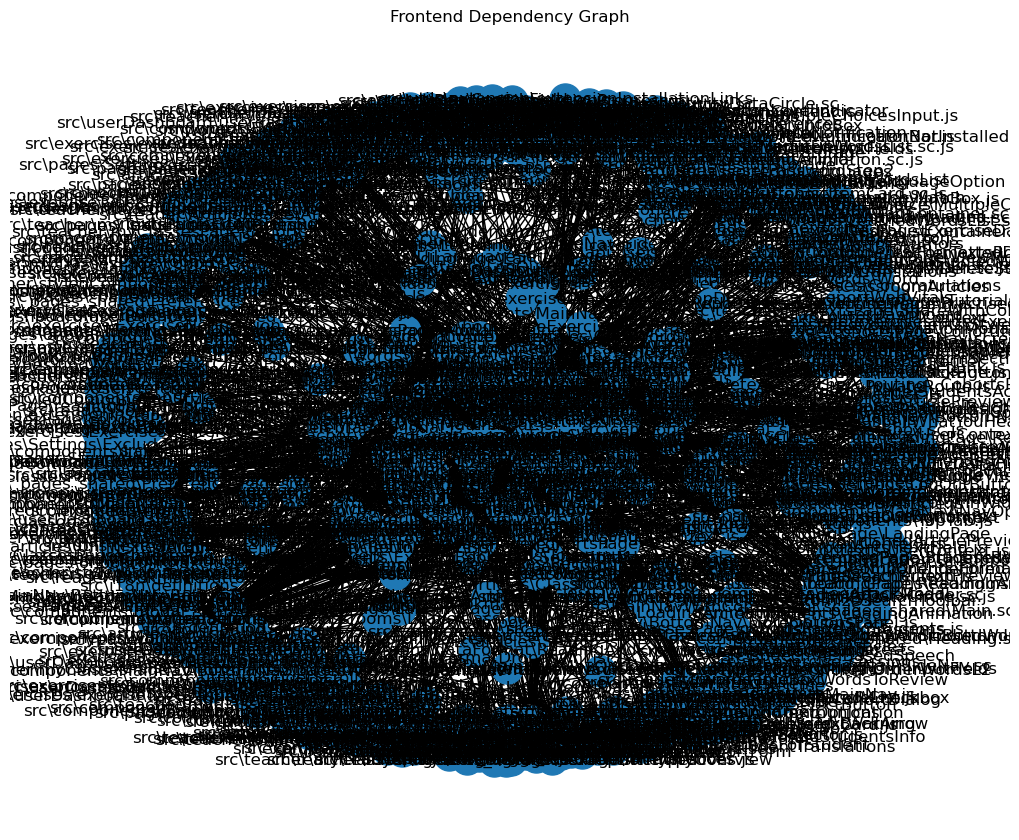

In [6]:
def draw_dependency_graph(G, title="Dependency Graph", figsize=(10, 8)):
    """
    Draws a directed dependency graph using matplotlib.
    """
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_size=500, arrowstyle='->', arrowsize=10)
    plt.title(title)
    plt.show()

# Visualize backend dependencies if available
if backend_deps.number_of_nodes() > 0:
    draw_dependency_graph(backend_deps, title="Backend Dependency Graph")
else:
    print("No backend dependency graph to display.")

# Visualize frontend dependencies if available
if frontend_deps.number_of_nodes() > 0:
    draw_dependency_graph(frontend_deps, title="Frontend Dependency Graph")
else:
    print("No frontend dependency graph to display.")